In [60]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 亮度与色度量化表
light_table = [[16, 11, 10, 16, 24, 40, 51, 61],
               [12, 12, 14, 19, 26, 58, 60, 55],
               [14, 13, 16, 24, 40, 57, 69, 56],
               [14, 17, 22, 29, 51, 87, 80, 62],
               [18, 22, 37, 56, 68, 109, 103, 77],
               [24, 35, 55, 64, 81, 104, 113, 92],
               [49, 64, 78, 87, 103, 121, 120, 101],
               [72, 92, 95, 98, 112, 100, 103, 99]]
color_table = [
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]]

light = {'y': np.array(light_table).reshape(8, 8), 
         'c': np.array(color_table).reshape(8, 8)}


# 编码部分 核心三个函数zigzag difencode rlencode
def zigzag(roi):
    list = [] #存放编码
    x = 0;y = 0 #0-right,1-down, 2-rightup, 3-leftdown
    act = 0
    while(x != 7 or y != 7):
        list.append(roi[x][y])
        if(act == 0):
            y += 1
            if(x - 1 < 0): act = 3
            else: act = 2
        elif(act == 1):
            x += 1
            if(y - 1 < 0): act = 2
            else: act = 3
        elif(act == 2):
            x -= 1;y += 1
            if(x - 1 < 0 and y + 1 != 8): act = 0
            elif(y + 1 == 8): act = 1
            else: act = 2
        elif(act == 3):
            x += 1;y -= 1
            if(x + 1 == 8): act = 0
            elif(y - 1 < 0 and x + 1 != 8): act = 1
            else: act = 3
    list.append(roi[7][7])
    del list[0]
    return  list

def DifEncode(dc):
    dif_encode = []
    dif_encode.append(dc[0])
    for i in range(1, len(dc)):
        dif_encode.append(dc[i] - dc[i - 1])
    return  dif_encode

def RlEncode(ac):
    rl = []
    cnt = 0 #记录0的个数
    for i  in range(len(ac)):
        for j in range(len(ac[i])):
            if(cnt > 15):
                rl.append(15)
                rl.append(0)
                cnt = 0
            if(ac[i][j] == 0):
                cnt += 1
                #z最后一个元素为0，但0的个数不足15个
                if(i == len(ac) - 1 and j == len(ac[i]) - 1):
                    rl.append(cnt - 1)
                    rl.append(0)
            else:
                rl.append(cnt)
                rl.append(ac[i][j])
                cnt = 0
    return rl

# 解码部分 dezigzag difdecode rldecode
def Dezigzag(dc, ac):
    roi = np.ones((8,8))
    roi[0][0] = dc
    cnt = 0
    for i in range(1,8):
        if(i % 2 == 1):
            for j in range(0,i + 1):
                roi[j][i - j] = ac[cnt]
                cnt += 1
        else:
            for j in range(0,i + 1):
                roi[i - j][j] = ac[cnt]
                cnt += 1

    for i in range(1,8):
        if(i % 2 == 1):
            for j in range(i, 8):
                roi[i + 7 - j][j] = ac[cnt]
                cnt += 1
        else:
            for j in range(i, 8):
                roi[j][i + 7 - j] = ac[cnt]
                cnt += 1
    return roi
def DifDecode(difencode):
    dc = []
    dc.append(difencode[0])
    for i in range(1, len(difencode)):
        dc.append(dc[i - 1] + difencode[i])
    return dc
def RlDecode(rl):
    ac = []
    lst = []
    for i in range(0, len(rl),2):
        cnt = rl[i]
        for j in range(cnt):
            lst.append(0)
        lst.append(rl[i + 1])
    t = []
    for i in range(0,len(lst),63):
        for j in range(63):
            t.append(lst[i+j])
        ac.append(t)
        t = []
    return ac

# 封装对每个通道的编码和解码操作
def Encode(y, channel='y'):
    light_table = light[channel]
    y_dc = []
    y_ac = []
    img_part = []
    for r in range(0, y.shape[0], 8):
        for c in range(0, y.shape[1], 8):
            reg = (y[r:r+8, c:c+8] - 128).astype(float)
            r_dct = cv2.dct(reg)
            light_num = np.around(r_dct / light[channel])
            y_dc.append(light_num[0, 0])
            y_ac.append(zigzag(light_num))
        
    y_difencode = DifEncode(y_dc)
    y_rlencode = RlEncode(y_ac)    
    
    return y_difencode, y_rlencode, channel
    
def Decode(y_difencode, y_rlencode, channel='y'):
    length = len(y_difencode)
    de_y_dc = DifDecode(y_difencode)
    de_y_ac = RlDecode(y_rlencode)
    y_cp = np.zeros((length, length), dtype=np.uint8)
    i = 0
    # 对每一块解码
    for r in range(0, length , 8):
        for c in range(0, length, 8):
            reg = Dezigzag(de_y_dc[i], de_y_ac[i])
            light_num = reg * light[channel]
            idct = cv2.idct(light_num) + 128
            res = np.around(idct).astype(np.uint8)
            y_cp[r:r+8, c:c+8] += res
            i += 1
    return y_cp

def main():
    filepath = 'lena.jpg'
    channel = ['y', 'c', 'c']
    # 读入图像
    img = cv2.imread('lena.jpg')
    plt.imshow(img)
    plt.show()
    # 色彩空间转换
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

    # 分割颜色通道
    channels = cv2.split(img)
    de_channel = []
    for i in range(3):
        de_channel.append(Decode(*Encode(channels[i], channel[i])))
    img = cv2.merge(de_channel)
    img = cv2.cvtColor(img, cv2.COLOR_YCR_CB2RGB)
    return img

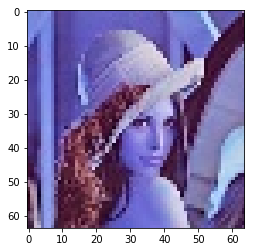

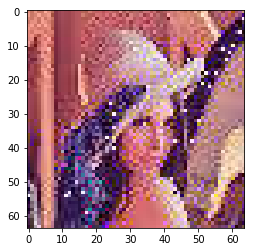

In [61]:
plt.imshow(main())
plt.show()